In [1]:
import numpy as np
import cvxpy as cp
from nldg.utils import max_mse, min_xplvar, gen_data_v2, gen_data_v3
import matplotlib.pyplot as plt
import seaborn as sns

In [165]:
dtr = gen_data_v2(n=1000)
Xtr = np.array(dtr.drop(columns=['E', 'Y']))
Ytr = np.array(dtr['Y'])
Ytr = Ytr - np.mean(Ytr)
dtr['Y'] = Ytr
Etr = np.array(dtr['E'])
Xtr_sorted = np.sort(Xtr, axis=0)

In [169]:
c = cp.Variable(1)
t = cp.Variable(nonneg=True)

mask_env0 = (Etr == 0)
mask_env1 = (Etr == 1)

Y_env0 = Ytr[mask_env0]
Y_env1 = Ytr[mask_env1]

constraints = []
constraints.append(cp.sum(cp.square(Y_env0 - c)) <= t)
constraints.append(cp.sum(cp.square(Y_env1 - c)) <= t)

objective_maximin = cp.Minimize(t)
problem_maximin = cp.Problem(objective_maximin, constraints)
problem_maximin.solve()

np.float64(162.56147051022208)

In [170]:
c.value

array([0.0032091])

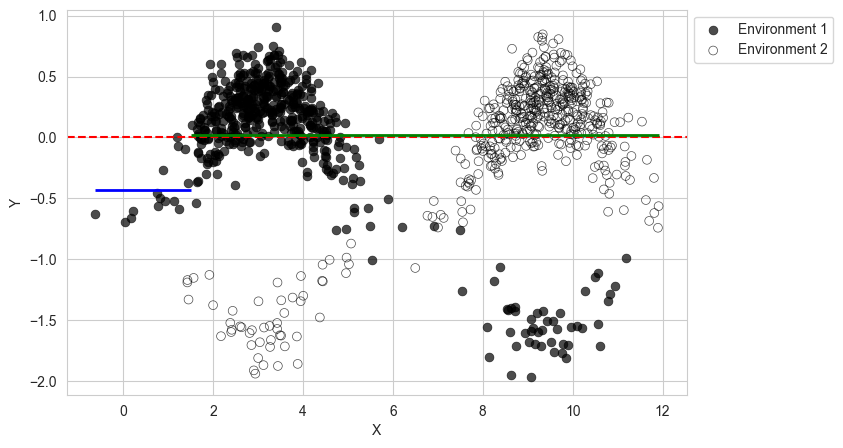

In [148]:
cL = cp.Variable(1)
cR = cp.Variable(1)
t = cp.Variable(nonneg=True)

lim = 1.5

mask_env0 = (Etr == 0)
mask_env1 = (Etr == 1)

X_env0 = Xtr[mask_env0].flatten()
X_env1 = Xtr[mask_env1].flatten()

Y_env0 = Ytr[mask_env0]
Y_env1 = Ytr[mask_env1]

constraints = []
constraints.append(cp.sum(cp.square(Y_env0[X_env0 <= lim] - cL)) + cp.sum(cp.square(Y_env0[X_env0 > lim] - cR)) <= t)
constraints.append(cp.sum(cp.square(Y_env1[X_env1 <= lim] - cL)) + cp.sum(cp.square(Y_env1[X_env1 > lim] - cR)) <= t)

objective_maximin = cp.Minimize(t)
problem_maximin = cp.Problem(objective_maximin, constraints)
problem_maximin.solve()

plt.figure(figsize=(8, 5))

sns.scatterplot(
    data=dtr[dtr["E"] == dtr["E"].unique()[0]],
    x="X", y="Y",
    color="black", edgecolor="black",
    s=40, alpha=0.7, label="Environment 1"
)

sns.scatterplot(
    data=dtr[dtr["E"] == dtr["E"].unique()[1]],
    x="X", y="Y",
    facecolors='none', edgecolor="black",
    s=40, alpha=0.7, label="Environment 2"
)

plt.axhline(y=c.value, color='r', linestyle='--')
plt.hlines(y=cL.value, xmin=dtr["X"].min(), xmax=lim, color='b', linestyle='-', linewidth=2)
plt.hlines(y=cR.value, xmin=lim, xmax=dtr["X"].max(), color='g', linestyle='-', linewidth=2)

plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

Optimal t = 154.35418893408612
Optimal prediction for Region 0 (X < 2.0): [-0.19671591]
Optimal prediction for Region 1 (2.0 <= X < 4.0): [0.08756003]
Optimal prediction for Region 2 (4.0 <= X < 6.0): [-0.1350227]
Optimal prediction for Region 3 (6.0 <= X < 8.0): [-0.38880765]
Optimal prediction for Region 4 (8.0 <= X < 11.0): [0.03894718]
Optimal prediction for Region 5 (X >= 11.0): [-0.34176609]


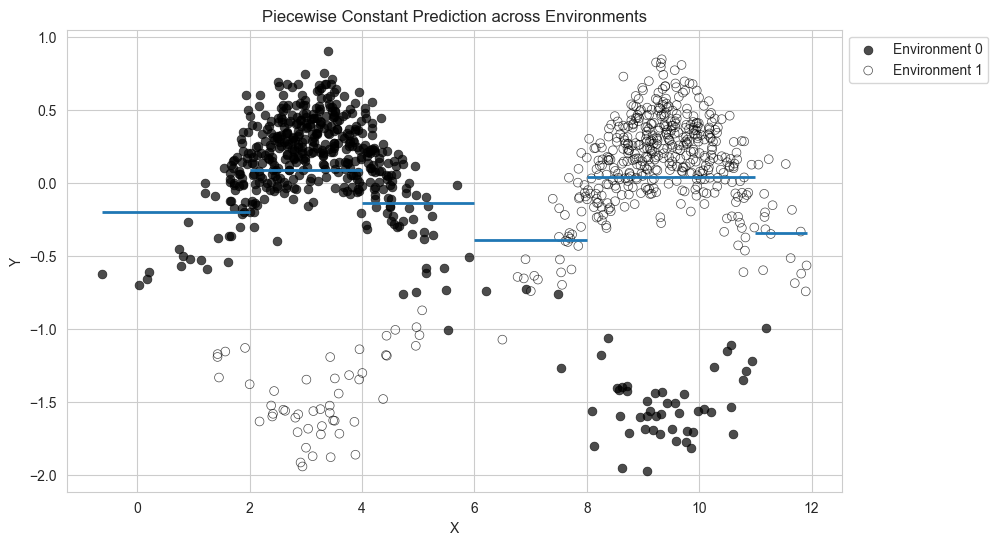

In [6]:
thresholds = [2, 4, 6, 8, 11]  # thresholds: 2, 4, 6, 8, 11

# Define the region masks based on X
mask_region0 = dtr["X"] < thresholds[0]
mask_region1 = (dtr["X"] >= thresholds[0]) & (dtr["X"] < thresholds[1])
mask_region2 = (dtr["X"] >= thresholds[1]) & (dtr["X"] < thresholds[2])
mask_region3 = (dtr["X"] >= thresholds[2]) & (dtr["X"] < thresholds[3])
mask_region4 = (dtr["X"] >= thresholds[3]) & (dtr["X"] < thresholds[4])
mask_region5 = dtr["X"] >= thresholds[4]

# Split the data by environment.
unique_envs = dtr["E"].unique()
mask_env0 = dtr["E"] == unique_envs[0]
mask_env1 = dtr["E"] == unique_envs[1]

# For each environment and region, extract the corresponding Y values as numpy arrays.
Y_env0_0 = dtr.loc[mask_env0 & mask_region0, "Y"].values
Y_env0_1 = dtr.loc[mask_env0 & mask_region1, "Y"].values
Y_env0_2 = dtr.loc[mask_env0 & mask_region2, "Y"].values
Y_env0_3 = dtr.loc[mask_env0 & mask_region3, "Y"].values
Y_env0_4 = dtr.loc[mask_env0 & mask_region4, "Y"].values
Y_env0_5 = dtr.loc[mask_env0 & mask_region5, "Y"].values

Y_env1_0 = dtr.loc[mask_env1 & mask_region0, "Y"].values
Y_env1_1 = dtr.loc[mask_env1 & mask_region1, "Y"].values
Y_env1_2 = dtr.loc[mask_env1 & mask_region2, "Y"].values
Y_env1_3 = dtr.loc[mask_env1 & mask_region3, "Y"].values
Y_env1_4 = dtr.loc[mask_env1 & mask_region4, "Y"].values
Y_env1_5 = dtr.loc[mask_env1 & mask_region5, "Y"].values

# --- Set up the Optimization Problem ---
# Define six scalar prediction variables, one per region.
c0 = cp.Variable(1)
c1 = cp.Variable(1)
c2 = cp.Variable(1)
c3 = cp.Variable(1)
c4 = cp.Variable(1)
c5 = cp.Variable(1)

# t is the common upper bound on the sum of squared errors in each environment.
t = cp.Variable(nonneg=True)

# Build constraints for each environment (sum of squared errors in each environment <= t)
constraints = []

# For environment 0, add the sum of squared errors over all regions.
constraints.append(
    cp.sum(cp.square(Y_env0_0 - c0)) +
    cp.sum(cp.square(Y_env0_1 - c1)) +
    cp.sum(cp.square(Y_env0_2 - c2)) +
    cp.sum(cp.square(Y_env0_3 - c3)) +
    cp.sum(cp.square(Y_env0_4 - c4)) +
    cp.sum(cp.square(Y_env0_5 - c5))
    <= t
)

# For environment 1:
constraints.append(
    cp.sum(cp.square(Y_env1_0 - c0)) +
    cp.sum(cp.square(Y_env1_1 - c1)) +
    cp.sum(cp.square(Y_env1_2 - c2)) +
    cp.sum(cp.square(Y_env1_3 - c3)) +
    cp.sum(cp.square(Y_env1_4 - c4)) +
    cp.sum(cp.square(Y_env1_5 - c5))
    <= t
)

# Define the objective to minimize the worst-case error t
objective = cp.Minimize(t)

# Solve the optimization problem
problem = cp.Problem(objective, constraints)
result = problem.solve()

print("Optimal t =", result)
print("Optimal prediction for Region 0 (X < {:.1f}): {}".format(thresholds[0], c0.value))
print("Optimal prediction for Region 1 ({:.1f} <= X < {:.1f}): {}".format(thresholds[0], thresholds[1], c1.value))
print("Optimal prediction for Region 2 ({:.1f} <= X < {:.1f}): {}".format(thresholds[1], thresholds[2], c2.value))
print("Optimal prediction for Region 3 ({:.1f} <= X < {:.1f}): {}".format(thresholds[2], thresholds[3], c3.value))
print("Optimal prediction for Region 4 ({:.1f} <= X < {:.1f}): {}".format(thresholds[3], thresholds[4], c4.value))
print("Optimal prediction for Region 5 (X >= {:.1f}): {}".format(thresholds[4], c5.value))

# --- Plotting ---
plt.figure(figsize=(10, 6))

# Plot the data points for each environment.
# For Environment 1, plot as filled circles.
sns.scatterplot(
    data=dtr[dtr["E"] == unique_envs[0]],
    x="X", y="Y",
    color="black", edgecolor="black",
    s=40, alpha=0.7, label="Environment {}".format(unique_envs[0])
)

# For Environment 2, plot with empty markers.
sns.scatterplot(
    data=dtr[dtr["E"] == unique_envs[1]],
    x="X", y="Y",
    facecolors='none', edgecolor="black",
    s=40, alpha=0.7, label="Environment {}".format(unique_envs[1])
)

# Draw horizontal lines showing the predictions in each region.
x_min = dtr["X"].min()
x_max = dtr["X"].max()

# Region 0: from x_min to thresholds[0]
plt.hlines(y=c0.value, xmin=x_min, xmax=thresholds[0], linestyle='-', linewidth=2)
# Region 1: from thresholds[0] to thresholds[1]
plt.hlines(y=c1.value, xmin=thresholds[0], xmax=thresholds[1], linestyle='-', linewidth=2)
# Region 2: from thresholds[1] to thresholds[2]
plt.hlines(y=c2.value, xmin=thresholds[1], xmax=thresholds[2], linestyle='-', linewidth=2)
# Region 3: from thresholds[2] to thresholds[3]
plt.hlines(y=c3.value, xmin=thresholds[2], xmax=thresholds[3], linestyle='-', linewidth=2)
# Region 4: from thresholds[3] to thresholds[4]
plt.hlines(y=c4.value, xmin=thresholds[3], xmax=thresholds[4], linestyle='-', linewidth=2)
# Region 5: from thresholds[4] to x_max
plt.hlines(y=c5.value, xmin=thresholds[4], xmax=x_max, linestyle='-', linewidth=2)

plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.title("Piecewise Constant Prediction across Environments")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.show()


In [7]:
pred = np.zeros(Xtr.shape[0])
pred[mask_region0] = c0.value
pred[mask_region1] = c1.value
pred[mask_region2] = c2.value
pred[mask_region3] = c3.value
pred[mask_region4] = c4.value
pred[mask_region5] = c5.value

In [8]:
max_mse(Ytr, pred, Etr, verbose=True)

Environment 0 MSE: 0.3087083779720158
Environment 1 MSE: 0.3087083779414585


np.float64(0.3087083779720158)

In [197]:
dtr = gen_data_v3(n=1000, setting=2)
Xtr = np.array(dtr.drop(columns=['E', 'Y']))
Ytr = np.array(dtr['Y'])
Ytr = Ytr - np.mean(Ytr)
dtr['Y'] = Ytr
Etr = np.array(dtr['E'])
Xtr_sorted = np.sort(Xtr, axis=0)

In [198]:
from nldg.train_nn import train_model_GDRO, predict_GDRO
from sklearn.preprocessing import StandardScaler
import torch

scaler = StandardScaler()
X_train = scaler.fit_transform(Xtr)
X_train_sorted = scaler.fit_transform(Xtr_sorted)

model, bweights = train_model_GDRO(X_train, Ytr, Etr, lr_model=0.01, hidden_dims=[128, 128, 128, 128])
preds_gdro = predict_GDRO(model, X_train_sorted)
fitted_gdro = predict_GDRO(model, X_train)

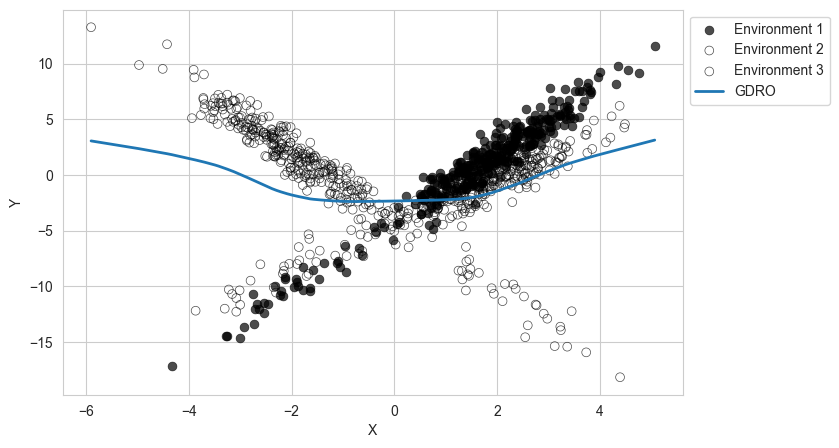

In [199]:
dtr["X_sorted"] = Xtr_sorted
dtr["fitted_gdro"] = preds_gdro

plt.figure(figsize=(8, 5))

scatter1 = sns.scatterplot(
    data=dtr[dtr["E"] == 0],
    x="X", y="Y",
    color="black", edgecolor="black",
    s=40, alpha=0.7,
    label="Environment 1"
)

sns.scatterplot(
    data=dtr[dtr["E"] == 1],
    x="X", y="Y",
    facecolors='none', edgecolor="black",
    s=40, alpha=0.7,
    label="Environment 2"
)

sns.scatterplot(
    data=dtr[dtr["E"] == 2],
    x="X", y="Y",
    facecolors='none', edgecolor="black",
    s=40, alpha=0.7,
    label="Environment 3"
)

line1, = plt.plot(dtr["X_sorted"], dtr["fitted_gdro"], linewidth=2, label="GDRO")

handles, labels = scatter1.get_legend_handles_labels()
method_legend = [line1]

plt.legend(handles=handles + method_legend, labels=labels, loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()


In [200]:
max_mse(Ytr, fitted_gdro, Etr, verbose=True)

Environment 0 MSE: 22.12464760445719
Environment 1 MSE: 26.001855522344265
Environment 2 MSE: 8.283728747070597


np.float64(26.001855522344265)

## TEST

In [120]:
dtr = gen_data_v2(n=1000)
Xtr = np.array(dtr.drop(columns=['E', 'Y']))
Ytr = np.array(dtr['Y'])
Ytr = Ytr - np.mean(Ytr)
dtr['Y'] = Ytr
Etr = np.array(dtr['E'])
Xtr_sorted = np.sort(Xtr, axis=0)

In [121]:
from numpy.random import default_rng

all_idx = default_rng(0).choice(np.arange(0, Xtr.shape[0]), size=Ytr.shape[0], replace=True)

Y_sample = Ytr[all_idx].flatten()
X_sample = Xtr[all_idx].flatten()
E_sample = Etr[all_idx].flatten()
unique_envs = np.unique(E_sample)

In [122]:
c_init = cp.Variable(1)
t = cp.Variable(nonneg=True)
constraints = []
for env in unique_envs:
    Y_e = Y_sample[E_sample == env]
    constraints.append(cp.mean(cp.square(Y_e - c_init)) <= t)
objective = cp.Minimize(t)
problem = cp.Problem(objective, constraints)
problem.solve()
best_preds = np.array([c_init.value] * Y_sample.shape[0])

In [123]:
c_init.value

array([0.02000007])

In [59]:
np.mean(Y_sample[E_sample==1])

np.float64(0.020008045544546688)

In [124]:
objective.value

np.float64(0.33174187531728594)

In [125]:
alpha = 0.1 * objective.value
alpha

np.float64(0.03317418753172859)

In [126]:
objective.value + alpha

np.float64(0.3649160628490145)

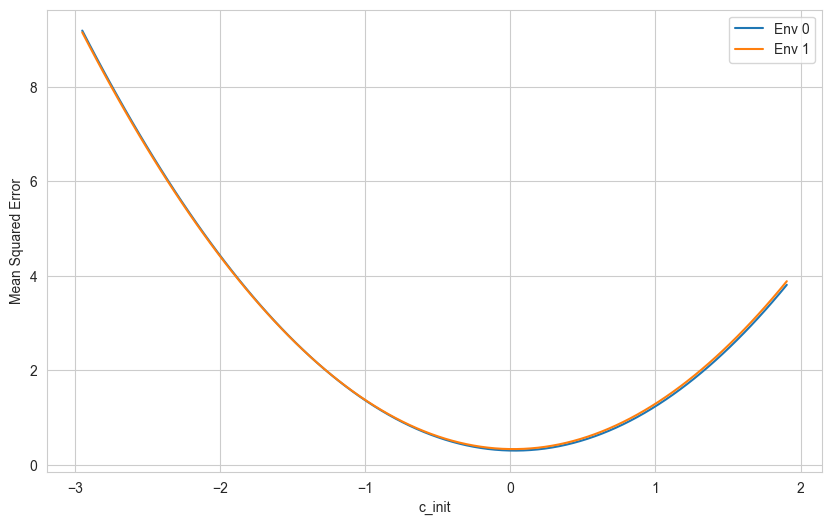

In [127]:
import numpy as np
import matplotlib.pyplot as plt

c_values = np.linspace(Y_sample.min() - 1, Y_sample.max() + 1, 100)

env_losses = {env: [] for env in unique_envs}

for c in c_values:
    for env in unique_envs:
        Y_e = Y_sample[E_sample == env]
        loss = np.mean((Y_e - c)**2)
        env_losses[env].append(loss)

plt.figure(figsize=(10, 6))
for env in unique_envs:
    plt.plot(c_values, env_losses[env], label=f'Env {env}')
plt.xlabel('c_init')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()


In [141]:
cL = cp.Variable(1)
cR = cp.Variable(1)
t = cp.Variable(nonneg=True)

indices = all_idx
order = np.argsort(Xtr[indices].flatten())
sorted_indices = indices[order]
sorted_X = Xtr[sorted_indices]

split_idx = 500

# Split based on the threshold
left_indices = sorted_indices[:split_idx]
right_indices = sorted_indices[split_idx:]

E_left = Etr[left_indices]
E_right = Etr[right_indices]
Y_left = Ytr[left_indices]
Y_right = Ytr[right_indices]

remaining = np.setdiff1d(all_idx, indices)

constraints = []
mean_diff_score = 0

for env in unique_envs:
    mask_left = E_left == env
    mask_right = E_right == env
    Y_e_left = Y_left[mask_left]
    Y_e_right = Y_right[mask_right]
    constraint_expr = 0
    if Y_e_left.size > 0:
        constraint_expr += cp.sum(cp.square(Y_e_left - cL))
    if Y_e_right.size > 0:
        constraint_expr += cp.sum(cp.square(Y_e_right - cR))
    if len(remaining) > 0:
        constraint_expr += cp.sum(cp.square(Ytr[remaining] - best_preds[remaining]))
    constraint_expr /= np.sum(Etr[all_idx] == env)
    constraints.append(constraint_expr <= t)

    mean_left = np.mean(Y_left[mask_left])
    mean_right = np.mean(Y_right[mask_right])
    mean_diff_score += abs(mean_right - mean_left)

mean_diff_score /= len(unique_envs)
#penalty = cp.abs(len(left_indices)/len(indices)-0.5)
objective_maximin = cp.Minimize(t + alpha / mean_diff_score)
problem_maximin = cp.Problem(objective_maximin, constraints)
problem_maximin.solve()

best_preds[left_indices] = cL.value
best_preds[right_indices] = cR.value

In [142]:
mean_diff_score

np.float64(1.4681825255063274)

In [143]:
objective_maximin.value

np.float64(0.3382132765704158)

In [144]:
cL.value

array([0.0001066])

In [145]:
cR.value

array([0.05343206])

In [133]:
envs = [0,1]
nL = {}
nR = {}
d  = {}
muL = {}
muR = {}

for i in envs:
    maskL = E_left  == i
    maskR = E_right == i

    YL = Y_left[maskL]
    YR = Y_right[maskR]
    Rem = Ytr[Etr == i]  # includes both splits + remaining

    nL[i] = YL.size
    nR[i] = YR.size
    d[i]  = Rem.size

    muL[i] = YL.mean() if YL.size>0 else 0.0
    muR[i] = YR.mean() if YR.size>0 else 0.0

# 2) compute weights
A0L, A1L = nL[0]/d[0], nL[1]/d[1]
A0R, A1R = nR[0]/d[0], nR[1]/d[1]
mu0L, mu1L = muL[0],   muL[1]
mu0R, mu1R = muR[0],   muR[1]

# 3) analytic intersection
cL_star = (A0L*mu0L - A1L*mu1L) / (A0L - A1L)
cR_star = (A0R*mu0R - A1R*mu1R) / (A0R - A1R)

In [134]:
cL_star

np.float64(0.47168773589331914)

In [135]:
cR_star

np.float64(0.37822976662936253)

In [ ]:
c_vals = np.linspace(Ytr.min() - 1, Ytr.max() + 1, 200)
C_L, C_R = np.meshgrid(c_vals, c_vals)

indices = all_idx
order = np.argsort(Xtr[indices].flatten())
sorted_indices = indices[order]

split_idx = 500
left_indices = sorted_indices[:split_idx]
right_indices = sorted_indices[split_idx:]
remaining = np.setdiff1d(all_idx, indices)

E_left = Etr[left_indices]
E_right = Etr[right_indices]
Y_left = Ytr[left_indices]
Y_right = Ytr[right_indices]

# Dict to store MSE heatmaps per environment
env_mse_maps = {env: np.zeros_like(C_L) for env in unique_envs}

# Compute loss per (cL, cR) pair
for i in range(C_L.shape[0]):
    for j in range(C_L.shape[1]):
        cL_val = C_L[i, j]
        cR_val = C_R[i, j]

        for env in unique_envs:
            mask_left = E_left == env
            mask_right = E_right == env
            loss = 0
            count = 0

            if np.any(mask_left):
                Y_e_left = Y_left[mask_left]
                loss += np.sum((Y_e_left - cL_val) ** 2)
                count += len(Y_e_left)

            if np.any(mask_right):
                Y_e_right = Y_right[mask_right]
                loss += np.sum((Y_e_right - cR_val) ** 2)
                count += len(Y_e_right)

            if len(remaining) > 0:
                Y_remain = Ytr[remaining]
                loss += np.sum((Y_remain - best_preds[remaining]) ** 2)
                count += len(Y_remain)

            mse = loss / count if count > 0 else 0
            env_mse_maps[env][i, j] = mse

# Plot heatmaps per environment
fig, axes = plt.subplots(1, len(unique_envs), figsize=(6 * len(unique_envs), 5))
if len(unique_envs) == 1:
    axes = [axes]

for ax, env in zip(axes, unique_envs):
    c = ax.contourf(C_L, C_R, env_mse_maps[env], levels=50, cmap='viridis')
    ax.set_title(f'Env {env} MSE')
    ax.set_xlabel('cL')
    ax.set_ylabel('cR')
    ax.plot(cL.value, cR.value, 'ro')
    fig.colorbar(c, ax=ax)

plt.tight_layout()
plt.show()


In [ ]:
import plotly.graph_objects as go
import numpy as np

# Define Z0 and Z1 for env 0 and env 1
Z0 = env_mse_maps[0]
Z1 = env_mse_maps[1]

# Find approximate intersection points (where MSEs are close)
epsilon = 1e-3
intersection_mask = np.abs(Z0 - Z1) < epsilon
intersection_points = np.where(intersection_mask)

# Create Plotly surface plots
fig = go.Figure()

# Env 0 surface
fig.add_trace(go.Surface(
    z=Z0, x=C_L, y=C_R,
    colorscale='Blues',
    opacity=0.7,
    name='Env 0 MSE',
    showscale=False
))

# Env 1 surface
fig.add_trace(go.Surface(
    z=Z1, x=C_L, y=C_R,
    colorscale='Oranges',
    opacity=0.7,
    name='Env 1 MSE',
    showscale=False
))

# Intersection region (scatter)
if intersection_points[0].size > 0:
    inter_x = C_L[intersection_points]
    inter_y = C_R[intersection_points]
    inter_z = Z0[intersection_points]  # or Z1, they are ~equal here
    fig.add_trace(go.Scatter3d(
        x=inter_x,
        y=inter_y,
        z=inter_z,
        mode='markers',
        marker=dict(size=3, color='black'),
        name='Intersection'
    ))

i_opt = np.argmin(np.abs(c_vals - cL.value))
j_opt = np.argmin(np.abs(c_vals - cR.value))

z0_opt = Z0[i_opt, j_opt]
z1_opt = Z1[i_opt, j_opt]

# Red dot on Env 0 surface
fig.add_trace(go.Scatter3d(
    x=[cL.value],
    y=[cR.value],
    z=[z0_opt],
    mode='markers',
    marker=dict(size=6, color='red'),
    name='Optimized (Env 0)'
))

# Red dot on Env 1 surface
fig.add_trace(go.Scatter3d(
    x=[cL.value],
    y=[cR.value],
    z=[z1_opt],
    mode='markers',
    marker=dict(size=6, color='darkred'),
    name='Optimized (Env 1)'
))

# Layout
fig.update_layout(
    title="MSE Surfaces and Intersection (Env 0 & Env 1)",
    scene=dict(
        xaxis_title='cL',
        yaxis_title='cR',
        zaxis_title='MSE',
    ),
    width=900,
    height=700
)

fig.show()


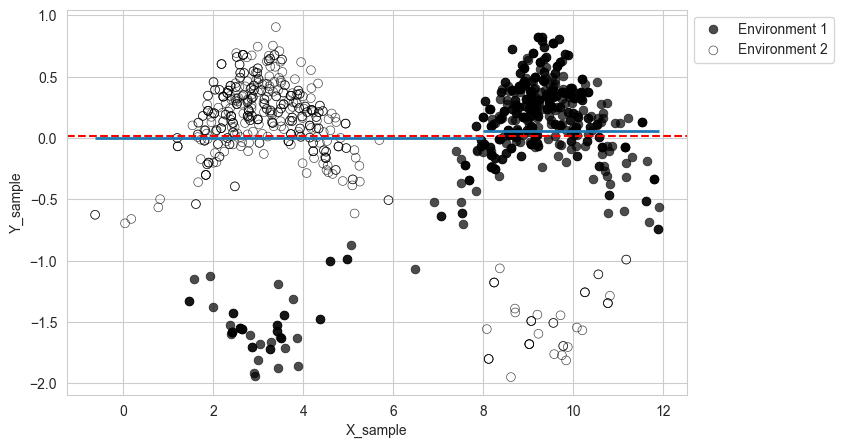

In [37]:
dtr['E_sample'] = E_sample
dtr['Y_sample'] = Y_sample
dtr['X_sample'] = X_sample
dtr["best_preds"] = best_preds

plt.figure(figsize=(8, 5))

# Plot data points
sns.scatterplot(
    data=dtr[dtr["E_sample"] == dtr["E_sample"].unique()[0]],
    x="X_sample", y="Y_sample",
    color="black", edgecolor="black",
    s=40, alpha=0.7, label="Environment 1"
)

sns.scatterplot(
    data=dtr[dtr["E_sample"] == dtr["E_sample"].unique()[1]],
    x="X_sample", y="Y_sample",
    facecolors='none', edgecolor="black",
    s=40, alpha=0.7, label="Environment 2"
)

# Plot the minimax constant prediction
plt.axhline(y=c_init.value, color='r', linestyle='--')

# Plot the step function from left to right
threshold = (sorted_X[split_idx-1] + sorted_X[split_idx]) / 2.0
plt.hlines(y=cL.value, xmin=dtr["X"].min(), xmax=threshold, linestyle='-', linewidth=2)
plt.hlines(y=cR.value, xmin=threshold, xmax=dtr["X"].max(), linestyle='-', linewidth=2)

plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

In [15]:
from collections import Counter

indices = all_idx
#indices = sorted_indices[best_split_idx:]
order = np.argsort(Xtr[indices].flatten())
sorted_indices = indices[order]
sorted_X = Xtr[sorted_indices]
diff = Counter(all_idx) - Counter(indices)
remaining = np.array(list(diff.elements()), dtype=np.intc)

best_score = np.inf
best_split_idx = None
best_values = None

for i in range(len(all_idx)-1):
    split_idx = i+1

    cL = cp.Variable(1)
    cR = cp.Variable(1)
    t = cp.Variable(nonneg=True)

    left_indices = sorted_indices[:split_idx]
    right_indices = sorted_indices[split_idx:]

    E_left = Etr[left_indices]
    E_right = Etr[right_indices]
    Y_left = Ytr[left_indices]
    Y_right = Ytr[right_indices]

    constraints = []
    mean_diff_score = 0
    count = 0

    for env in unique_envs:
        mask_left = E_left == env
        mask_right = E_right == env
        Y_e_left = Y_left[mask_left]
        Y_e_right = Y_right[mask_right]
        constraint_expr = 0
        if Y_e_left.size > 0:
            constraint_expr += cp.sum(cp.square(Y_e_left - cL))
        if Y_e_right.size > 0:
            constraint_expr += cp.sum(cp.square(Y_e_right - cR))
        if len(remaining) > 0:
            mask = Etr[remaining] == env
            Y_e_remaining = Ytr[remaining][mask]
            preds_e_remaining = best_preds[remaining][mask]
            constraint_expr += cp.sum(cp.square(Y_e_remaining - preds_e_remaining))
        constraint_expr /= np.sum(Etr[all_idx] == env)
        constraints.append(constraint_expr <= t)

        if np.sum(mask_left) > 0 and np.sum(mask_right) > 0:
            mean_left = np.mean(Y_left[mask_left])
            mean_right = np.mean(Y_right[mask_right])
            mean_diff_score += abs(mean_right - mean_left)
            count += 1

    mean_diff_score /= count

    objective_maximin = cp.Minimize(t + alpha / mean_diff_score)
    problem_maximin = cp.Problem(objective_maximin, constraints)
    problem_maximin.solve()

    if objective_maximin.value < best_score:
        best_values = [cL.value, cR.value]
        best_split_idx = split_idx
        best_score = objective_maximin.value

C:\Users\franc\OneDrive\Desktop\ETH\FS25\Thesis\nldg\50_code\venv_nldg\lib\site-packages\cvxpy\problems\problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [16]:
len(remaining)

0

In [17]:
best_split_idx

473

In [18]:
best_score

np.float64(0.3363057696001686)

In [19]:
#best_preds = np.array([c_init.value] * Y_sample.shape[0]).flatten()
best_preds[sorted_indices[:best_split_idx]] = best_values[0]
best_preds[sorted_indices[best_split_idx:]] = best_values[1]

In [20]:
np.unique(best_preds[all_idx])

array([-0.00384721,  0.05154391])

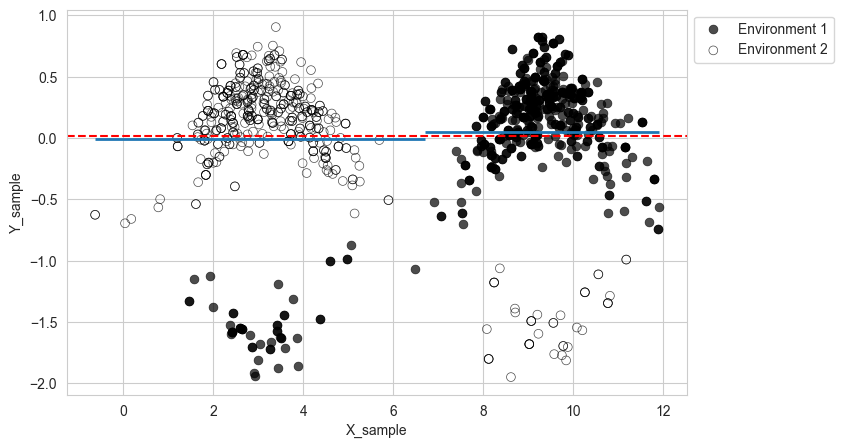

In [21]:
dtr['E_sample'] = E_sample
dtr['Y_sample'] = Y_sample
dtr['X_sample'] = X_sample
dtr["best_preds"] = best_preds

plt.figure(figsize=(8, 5))

# Plot data points
sns.scatterplot(
    data=dtr[dtr["E_sample"] == dtr["E_sample"].unique()[0]],
    x="X_sample", y="Y_sample",
    color="black", edgecolor="black",
    s=40, alpha=0.7, label="Environment 1"
)

sns.scatterplot(
    data=dtr[dtr["E_sample"] == dtr["E_sample"].unique()[1]],
    x="X_sample", y="Y_sample",
    facecolors='none', edgecolor="black",
    s=40, alpha=0.7, label="Environment 2"
)

# Plot the minimax constant prediction
plt.axhline(y=c_init.value, color='r', linestyle='--')

# Plot the step function from left to right
threshold = (sorted_X[best_split_idx-1] + sorted_X[best_split_idx]) / 2.0
plt.hlines(y=best_values[0], xmin=dtr["X"].min(), xmax=threshold, linestyle='-', linewidth=2)
plt.hlines(y=best_values[1], xmin=threshold, xmax=dtr["X"].max(), linestyle='-', linewidth=2)

plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

### TEST adaXT

In [1]:
import numpy as np
import cvxpy as cp
from nldg.utils import max_mse, min_xplvar, gen_data_v2, gen_data_v3
import matplotlib.pyplot as plt
import seaborn as sns
from adaXT.random_forest import RandomForest

In [2]:
dtr = gen_data_v2(n=1000)
Xtr = np.array(dtr.drop(columns=['E', 'Y']))
Ytr = np.array(dtr['Y'])
Ytr = Ytr - np.mean(Ytr)
dtr['Y'] = Ytr
Etr = np.array(dtr['E'])
Xtr_sorted = np.sort(Xtr, axis=0)
min_samples_leaf = 10
random_state = 42

In [7]:
rf = RandomForest("MaximinRegression",
                  n_estimators=1,
                  min_samples_leaf=min_samples_leaf,
                  seed=0,
                  #max_depth=1
                  )
rf.fit(Xtr, Ytr, Etr)
fitted = rf.predict(Xtr)

0.03266034856758632 0.32660348567586317
[0.03228349] 0.3592638342434495
-------------------------------------------------------
1000
Remaining:  0
Best split:  473 4.94940289546923
Impurity:  0.3592638342434495 0.323889338428104
Best values:  [array([0.06880575]), array([-0.01323207])]
Best preds:  (array([-0.01323207,  0.06880575]), array([527, 473]))
-------------------------------------------------------
527
Remaining:  473
Best split:  60 8.143048249186124
Impurity:  0.323889338428104 0.2941789952706535
Best values:  [array([-0.48175595]), array([-0.01708869])]
Best preds:  (array([-0.48175595, -0.01708869,  0.06880575]), array([ 60, 467, 473]))
-------------------------------------------------------
467
Remaining:  533
Best split:  415 10.563573478060091
Impurity:  0.2941789952706535 0.28703323476286075
Best values:  [array([-0.00476111]), array([-0.32174312])]
Best preds:  (array([-0.48175595, -0.32174312, -0.00476111,  0.06880575]), array([ 60,  52, 415, 473]))
-----------------

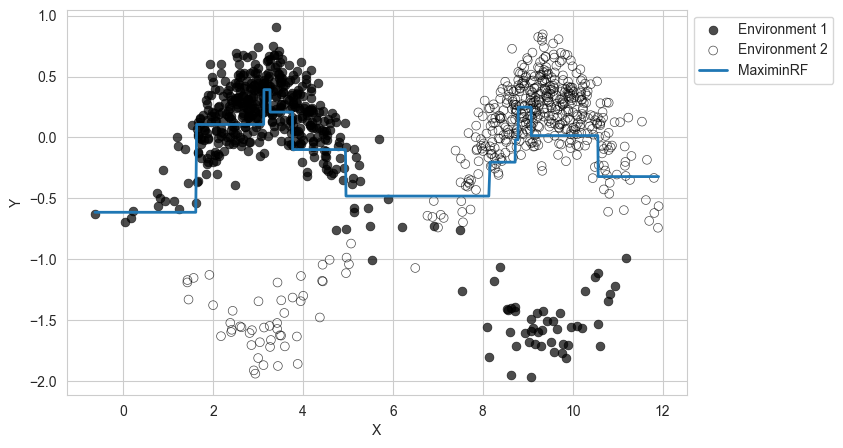

In [8]:
preds = rf.predict(Xtr_sorted)
dtr["X_sorted"] = Xtr_sorted
dtr["preds"] = preds

plt.figure(figsize=(8, 5))

scatter1 = sns.scatterplot(
    data=dtr[dtr["E"] == 0],
    x="X", y="Y",
    color="black", edgecolor="black",
    s=40, alpha=0.7,
    label="Environment 1"
)

scatter2 = sns.scatterplot(
    data=dtr[dtr["E"] == 1],
    x="X", y="Y",
    facecolors='none', edgecolor="black",
    s=40, alpha=0.7,
    label="Environment 2"
)

line1, = plt.plot(dtr["X_sorted"], dtr["preds"], linewidth=2, label="MaximinRF")

handles, labels = scatter1.get_legend_handles_labels()
method_legend = [line1]

plt.legend(handles=handles + method_legend, labels=labels, loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()
